In [2]:
import torch 
import numpy as np
import pandas as pd
from torch import nn
import torch.nn.functional as F
from sklearn.datasets import make_moons, load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
from ray import tune
import ray
from ray import train, tune
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search import ConcurrencyLimiter
import copy
import threading
from  sklearn.mixture import GaussianMixture as GMM
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super().__init__()
        self.input_size = input_size
        self.bottleneck_size = bottleneck_size
        self.hidden_size = hidden_size
        self.layers = layers
        self.hidden_layers_encoder = []
        self.hidden_layers_decoder = []
        
        
 
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, input_size)
        self.bottleneck_layer = nn.Linear(bottleneck_size, bottleneck_size)
        
        self.hidden_layers_decoder.append(nn.Linear(bottleneck_size, hidden_size))
        
        for i in range(layers -1):
            self.hidden_layers_encoder.append(nn.Linear(hidden_size, hidden_size))
            self.hidden_layers_encoder.append(nn.ReLU())
            self.hidden_layers_decoder.append(nn.Linear(hidden_size, hidden_size))
            self.hidden_layers_decoder.append(nn.ReLU())
            
        self.hidden_layers_encoder.append(nn.Linear(hidden_size, bottleneck_size))
        
        self.encoder = nn.Sequential(self.input_layer,
                                   *self.hidden_layers_encoder,
                                   self.bottleneck_layer)
        
        self.decoder = nn.Sequential(*self.hidden_layers_decoder,
                                   self.output_layer)
        
        self.model = nn.Sequential(self.encoder, self.decoder)
        
    
        
    def encode(self, x):
        return self.encoder(x)
        
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        return self.decode(self.encode(x))    
    
    def calculate_loss(self, X):
        error_type = nn.MSELoss()
        reconstructed = self.forward(X)
        loss = error_type(reconstructed, X)
        return loss
    
    def train_autoencoder(self, X_train, ts_size, epochs, lr=.01):
            indices = torch.randperm(len(X_train))[:ts_size]
            X_train = X_train[indices]
            error_type = nn.MSELoss()
            optimizer = torch.optim.Adam(self.parameters(), lr=lr)
            losses = []
            for epoch in range(epochs):
                loss = self.calculate_loss(X_train)
                losses.append(loss)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            
            return self, losses
                
    
    

In [4]:
def import_data(noise=0, random_state=1, shuffle=True, n_test=0.5, name="moons", n_samples = 2000):
    if name == "moons":
        data, _ = make_moons(noise=noise, random_state=random_state, shuffle=shuffle, n_samples=n_samples)        
        X_train, X_test= train_test_split(data, test_size=n_test, random_state=random_state)
        return torch.FloatTensor(X_train), torch.FloatTensor(X_test), None, None
    
    elif name == "digits":
        data, labels = load_digits(return_X_y = True)
        data = data.reshape((len(data), -1))
        noise =  np.random.normal(0, noise * data.max(), data.shape)
        X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=n_test, random_state=random_state)
        return torch.FloatTensor(X_train), torch.FloatTensor(X_test), torch.FloatTensor(Y_train), torch.FloatTensor(Y_test)

In [5]:
X_train, X_test, Y_train, Y_test = import_data(noise=0.1, n_test=0.1, name="moons")

In [6]:
def autoencoder_as_function_of_hyperparameters(config):
    auto, _ = AutoEncoder(config["input_size"], config["bottleneck_size"], 
                    config["hidden_size"], config["layers"]).train_autoencoder(X_train, 
                           config["ts_size"], 
                           config["epochs"], 
                           config["lr"])
    loss_func = nn.MSELoss()
    loss = float(loss_func(auto.forward(X_test), X_test).detach().numpy())
    metric = {"loss": loss }
    ray.train.report(metric
       )

In [16]:
config={"input_size":  tune.choice([2]), "bottleneck_size":  tune.choice([1]),
        "hidden_size":  tune.choice([x for x in range(20, 100, 20)]), 
        "layers":  tune.choice([x for x in range(1, 10)]),
        "ts_size":  tune.choice([x for x in range(100, 2000, 100)]),
        "epochs":  tune.choice([x for x in range(10, 400, 50)]),
        "lr": tune.choice([0.01, 0.001])}

from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.ax import AxSearch
def opt(config):
    ax_search = AxSearch()
    algo = OptunaSearch()
    algo = ConcurrencyLimiter(algo, max_concurrent=4)

    tuner = tune.Tuner(
        autoencoder_as_function_of_hyperparameters,
        tune_config=tune.TuneConfig(
            scheduler=ASHAScheduler(),
            search_alg=algo,
            metric="loss",
            mode="min",
            num_samples=10,
        ),
        param_space=config,
    )

    result = tuner.fit()
    return result.get_best_result().config
good_config = opt(config)


2023-11-20 19:05:36,891	INFO tune.py:1045 -- Total run time: 23.24 seconds (23.21 seconds for the tuning loop).


In [ ]:
good_config

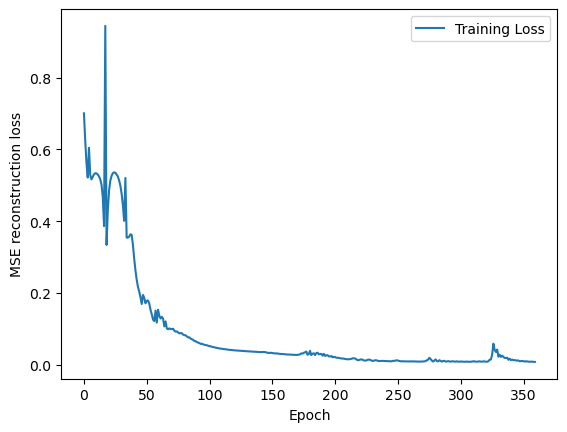

In [10]:
auto, loss_list = AutoEncoder(good_config["input_size"], good_config["bottleneck_size"], 
                    good_config["hidden_size"], good_config["layers"]).train_autoencoder(X_train, 
                           good_config["ts_size"], 
                           good_config["epochs"], 
                           good_config["lr"])
plt.plot(range(good_config["epochs"]), [l.detach().numpy() for l in loss_list], label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('MSE reconstruction loss')
plt.legend()
plt.show()


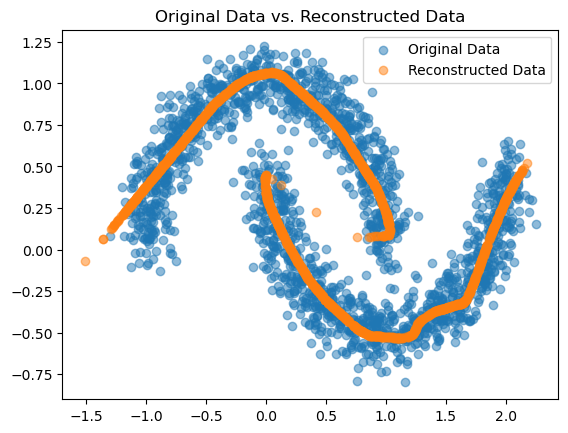

In [11]:
reconstructed_data = auto.forward(X_train).detach().numpy()
plt.scatter(X_train[:, 0], X_train[:, 1], label='Original Data', alpha=0.5)
plt.scatter(reconstructed_data[:,0],reconstructed_data[:,1], label='Reconstructed Data', alpha=0.5)
plt.legend()
plt.title('Original Data vs. Reconstructed Data')
plt.show()

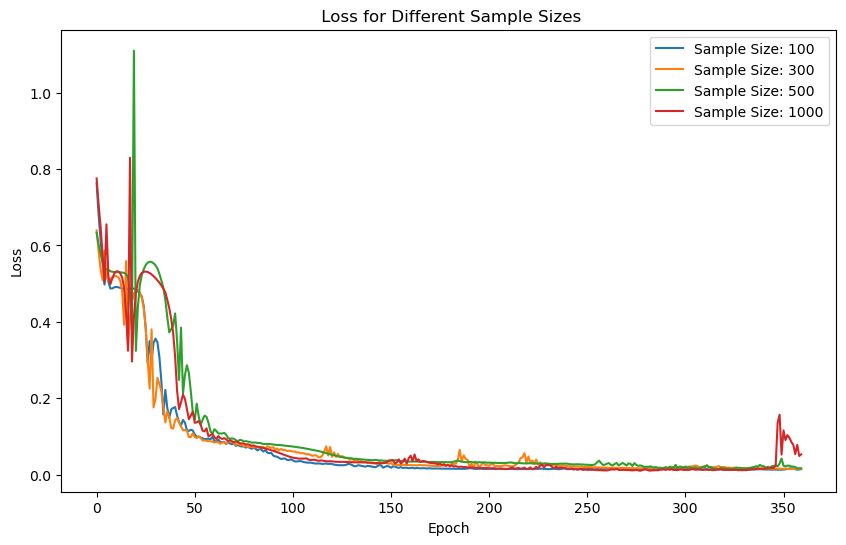

hidden_size: 100
layers: 5


In [13]:
#Train model with different data size
data_size = [100,300,500,1000]
num_epochs = 150

input_size=2
bottleneck_size=1
hidden_size=100
layers=5
Loss = []
for size in data_size:
    auto, loss_list  = AutoEncoder(good_config["input_size"], good_config["bottleneck_size"], 
                    good_config["hidden_size"], good_config["layers"]).train_autoencoder(X_train, 
                           size, 
                           good_config["epochs"], 
                           good_config["lr"])
    Loss.append([l.detach().numpy() for l in loss_list])


# Plot
plt.figure(figsize=(10, 6))
for i, size in enumerate(data_size):
    plt.plot(range(good_config["epochs"]), Loss[i], label=f"Sample Size: {size}")

plt.title(' Loss for Different Sample Sizes')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


print('hidden_size:', hidden_size)
print('layers:',layers)

In [14]:
def generate_plots():
    
    fig, axs = plt.subplots(2,3)
    fig.suptitle(f"Reconstruction error vs parameters")
    plt.ylabel("MSE Reconstruction")
    fig.tight_layout() 
    i = 0
    for param in good_config:
        loss = []
        if param == "input_size":
            continue
        x_axis = np.linspace(1, 2*good_config[param], 10, dtype=type(good_config[param]))
        gc = copy.deepcopy(good_config)
        for p in x_axis:
            gc[param] = p
            auto, _ =  AutoEncoder(gc["input_size"], gc["bottleneck_size"], 
                            gc["hidden_size"], gc["layers"]).train_autoencoder(X_train, 
                                   gc["ts_size"], 
                                   gc["epochs"], 
                                   gc["lr"])

            loss.append(float(auto.calculate_loss(X_test).detach().numpy()))

        axs[divmod(i, 3)].set_xlabel(f"{param}")
        axs[divmod(i, 3)].plot(x_axis, loss)
        axs[divmod(i, 3)].set_yscale('log')
        i += 1
    


    

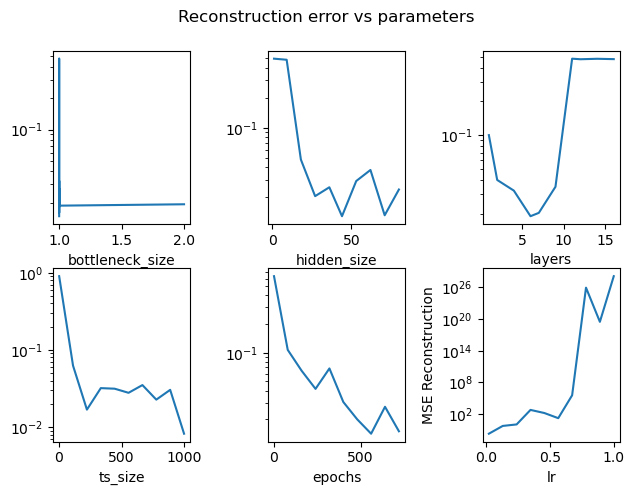

In [15]:
generate_plots()

In [ ]:
losses = []
def plot_loss_vs_hidden_size():
    loss = []
    for i in range(1, 20):
        print(i)
        auto, _ =  AutoEncoder(good_config["input_size"], i, 
                                    good_config["hidden_size"], good_config["layers"]).train_autoencoder(X_train, 
                                           good_config["ts_size"], 
                                           good_config["epochs"], 
                                           good_config["lr"])
        loss.append(float(auto.calculate_loss(X_test).detach().numpy()))
    losses.append(np.array(loss))

n = 10
threads = []
for i in range(n):
    thread = threading.Thread(target=plot_loss_vs_hidden_size)
    thread.start()
    threads.append(thread)
[t.join() for t in threads]
plt.title(f"Size of hidden layer vs MSE Reconstruction, averaged n={n}")
plt.xlabel("size of hidden layer")
plt.ylabel("MSE Reconstruction")
loss = np.array([0 for x in range(len(losses[0]))])
print(loss.shape)
for l in losses:
    loss = np.add(loss, l)
loss = loss/n
plt.plot([x for x in range(len(loss))], loss)


1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
5
5
5
5


In [ ]:
fig, axs = plt.subplots(2, 3)
fig.suptitle(f"Reconstruction with different code dimension")

j = 0
for i in [2, 4, 8]:
        auto, _ =  AutoEncoder(good_config["input_size"], i, 
                                    good_config["hidden_size"], good_config["layers"]).train_autoencoder(X_train, 
                                           good_config["ts_size"], 
                                           good_config["epochs"], 
                                           good_config["lr"])
        
        
        x = np.random.choice([i for i in range(len(X_test))])
        x = X_test[x]
        axs[0, j].imshow(x.reshape(8,8))
        axs[0, j].set_title("True data")
        axs[1, j].imshow(auto.forward(x).detach().numpy().reshape(8, 8))
        axs[1, j].set_title("Reconstructed data")
        axs[1, j].set_xlabel(f"dim(code) = {i}")
        j += 1

In [ ]:
n = 10
plt.title(f"Trial vs MSE Reconstruction")
plt.xlabel("Number of trial")
plt.ylabel("MSE Reconstruction")
loss = []
for i in range(n):
    auto, _ =  AutoEncoder(good_config["input_size"],good_config["bottleneck_size"] , 
                                    good_config["hidden_size"], good_config["layers"]).train_autoencoder(X_train, 
                                           good_config["ts_size"], 
                                           good_config["epochs"], 
                                           good_config["lr"])
    loss.append(float(auto.calculate_loss(X_test).detach().numpy()))

plt.plot(loss)


In [13]:
def get_z(X, auto=None, bs=None):
    if auto is None:
        auto, _ =  AutoEncoder(good_config["input_size"],(good_config["bottleneck_size"] if bs is None else bs), 
                                        good_config["hidden_size"], good_config["layers"]).train_autoencoder(X_train, 
                                               good_config["ts_size"], 
                                               good_config["epochs"], 
                                               good_config["lr"])
    return auto, auto.encode(X)

In [70]:
def plot_synthetic_data(bs, k):
    if bs != 0:
        auto, Z_train = get_z(X_test, bs=bs)
        _, Z_test = get_z(X_train, auto=auto)

        Z_train = Z_test.detach().numpy()
        Z_test = Z_test.detach().numpy()
        scores = []
        for n in range(1, 50):
            scores.append(GMM(n_components = n).fit(Z_train).bic(Z_test))
        gmm = GMM(n_components= np.argmin(scores)).fit(Z_test)
        samples = torch.FloatTensor(gmm.sample(k**2)[0])
        synthetic_data = auto.decode(samples)
    else:
        synthetic_data = X_test
    fig, ax = plt.subplots(k,k)
    for i in range(k**2):
        ax.flatten()[i].imshow(synthetic_data[i].detach().numpy().reshape(8,8))

C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak o

C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak o

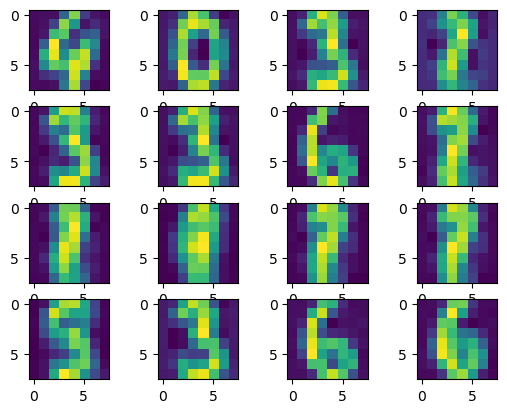

In [71]:
plot_synthetic_data(2, 4)

C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak o

C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak o

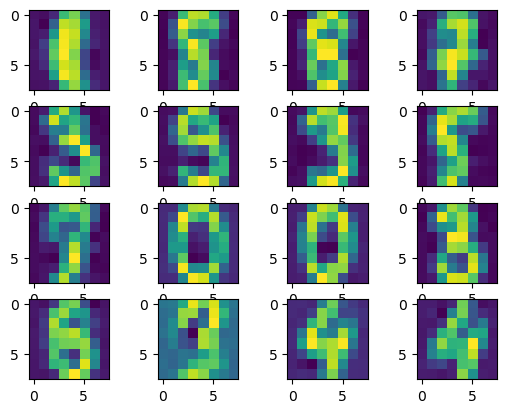

In [72]:
plot_synthetic_data(4, 4)

C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak o

C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak o

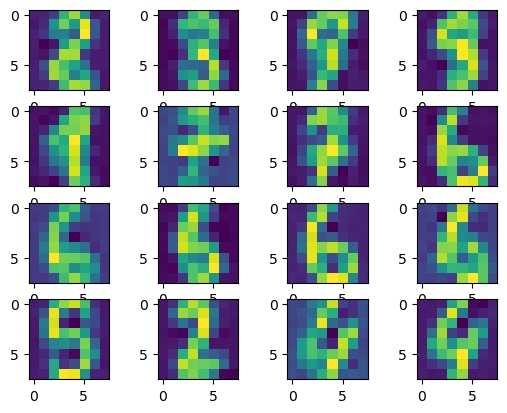

In [73]:
plot_synthetic_data(8, 4)

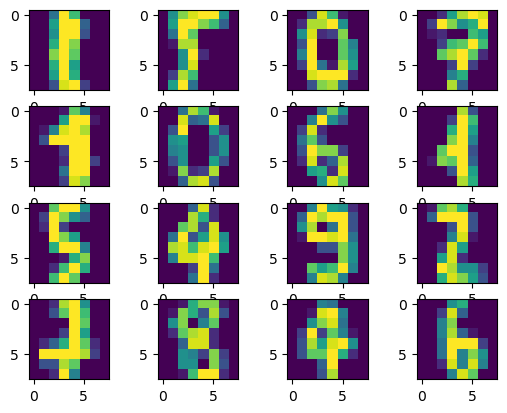

In [74]:
plot_synthetic_data(0, 4)

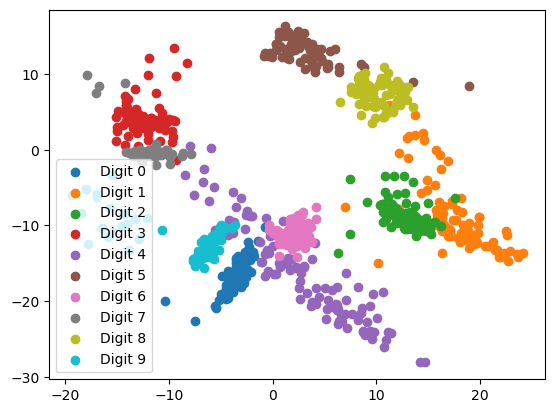

In [62]:
for i in range(10):
    _, z = get_z(X_test[np.where(Y_test == i)], bs=2)
    z = z.detach().numpy()
    plt.scatter(z.T[0], z.T[1], label=f"Digit {i}")
plt.legend()

In [47]:
print(z.T)

[[14.891422   12.420755   10.409484   11.503362   11.686427   11.11563
  11.230367   12.109011   13.0018015  10.073453   11.592901   11.93882
  11.339028   12.6634865  11.776524   12.403557   10.433646   12.350294
  12.833837   14.073136   14.484515    9.707895    9.911982   13.189918
  14.075643   12.682551   13.048253   11.077806   14.439369   13.296098
  11.747169   13.744719   11.526348   13.432219   10.136021   12.571914
  13.656792   13.719408   10.377575   11.545097   14.610167   11.78987
  14.448833   10.397082   12.181955   12.536864   12.567011   12.9415045
  12.785238   12.508636   12.659365   13.371188    9.009047   12.098908
  10.661253   11.860121   13.9182825  12.823526   11.945437   15.070246
  13.505406   13.626622   13.658603   12.016208   13.844705   13.324241
   9.118684   14.863187   12.662796   11.506638   13.484167   13.277208
  14.666825   14.090162   11.268064   10.8951845  10.85048     9.496815
  12.622725   13.122072   10.14836    13.82771    12.2544     10.7

In [77]:
def train_rfc(data, targets):
    p_grid = {"n_estimators":[100 * x for x in range(4)], "criterion" : ["gini", "entropy", "log_loss"], 
                             "max_features": ["sqrt", "log2", None]}
    rfc = HalvingGridSearchCV(RFC(), p_grid, refit=True, verbose=1, cv=3).fit(data, targets)
    return rfc.best_estimator_


In [80]:
rfc = train_rfc(X_train, Y_train)

n_iterations: 3
n_required_iterations: 4
n_possible_iterations: 3
min_resources_: 60
max_resources_: 898
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 36
n_resources: 60
Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
27 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Florian\anaconda3\Lib\sit

----------
iter: 1
n_candidates: 12
n_resources: 180
Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [       nan 0.79385965 0.74122807 0.82807018        nan 0.75789474
 0.75964912 0.75964912        nan 0.65614035 0.67368421 0.67368421
        nan 0.74210526 0.74210526 0.74210526        nan 0.70614035
 0.7245614  0.7245614         nan 0.6377193  0.62105263 0.6377193
        nan 0.70789474 0.70701754 0.75877193        nan 0.69035088
 0.7245614  0.7245614         nan 0.65526316 0.62105263 0.62017544
 0.88229755 0.87099812 0.876742   0.85404896 0.87655367 0.88785311
 0.85433145 0.88229755 0.876742   0.85998117 0.85414313 0.88229755]
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the train scores are non-finite: [nan  1.  1.  1. nan  1.  1.  1. nan  1.  1.  1. nan  1.  1.  1. nan  1.
  1.  1. nan  1.  1.  1. nan  1.  1.  1. nan  1.  1.  1. nan  1.  1.  1.
  1.  1.  

----------
iter: 2
n_candidates: 4
n_resources: 540
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [       nan 0.79385965 0.74122807 0.82807018        nan 0.75789474
 0.75964912 0.75964912        nan 0.65614035 0.67368421 0.67368421
        nan 0.74210526 0.74210526 0.74210526        nan 0.70614035
 0.7245614  0.7245614         nan 0.6377193  0.62105263 0.6377193
        nan 0.70789474 0.70701754 0.75877193        nan 0.69035088
 0.7245614  0.7245614         nan 0.65526316 0.62105263 0.62017544
 0.88229755 0.87099812 0.876742   0.85404896 0.87655367 0.88785311
 0.85433145 0.88229755 0.876742   0.85998117 0.85414313 0.88229755
 0.95537968 0.95910408 0.95536934 0.95351748]
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the train scores are non-finite: [nan  1.  1.  1. nan  1.  1.  1. nan  1.  1.  1. nan  1.  1.  1. nan  1.
  1.  1. nan  1.  1.  1. nan  1.  1.  

In [86]:
rfc.score(X_test, Y_test)

0.9721913236929922

In [127]:
def reconstruction_quality():
    fig, ax = plt.subplots(1, 3)
    j = 0
    for i in [2,4,8]:
        auto, _ =  AutoEncoder(good_config["input_size"],i, 
                                            good_config["hidden_size"], good_config["layers"]).train_autoencoder(X_train, 
                                                   good_config["ts_size"], 
                                                   good_config["epochs"], 
                                                   good_config["lr"])
        reconstructed = auto.forward(X_test).detach().numpy()
        predictions = rfc.predict(reconstructed)
        diff = Y_test - predictions
        correct = len(np.where(abs(diff) <= 1E-8)[0])
        false = len(Y_test) - correct
        ax[j].bar(["right", "wrong"], [correct, false])
        j += 1
    
    

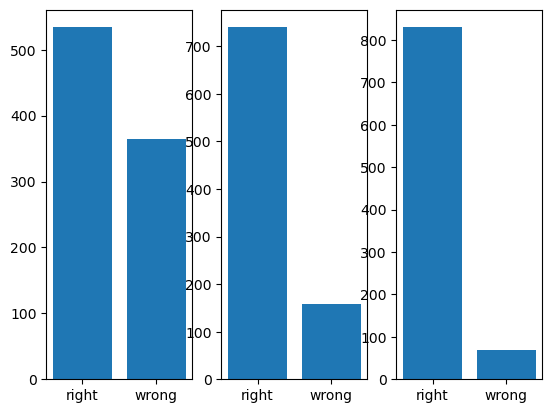

In [128]:
reconstruction_quality()